In [1]:
#! pip install nibabel nipype -U

In [2]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
path = "./Task04_Hippocampus/3d_fullres"

run_data = [
    "A40/22933937",
    "A100/22933910",
    "A100/22969078",
    "A100/22972197",
    "A100/22972221",
]

validation_raw_numbers = [
    "017",
    "019",
    "033",
    "035",
    "037",
    "049",
    "052",
    "065",
    "083",
    "088",
    "090",
    "092",
    "095",
    "107",
    "108",
    "123",
    "125",
    "157",
    "164",
    "169",
    "175",
    "185",
    "190",
    "194",
    "204",
    "205",
    "210",
    "217",
    "219",
    "229",
    "244",
    "261",
    "264",
    "277",
    "280",
    "286",
    "288",
    "289",
    "296",
    "305",
    "308",
    "317",
    "327",
    "330",
    "332",
    "338",
    "349",
    "350",
    "356",
    "358",
    "374",
    "394",
]

results = []

In [5]:
import nipype.algorithms.metrics

# Calculate dice score
for run in run_data:

    run_info = {}
    run_info[run] = {}

    for validation_raw_number in validation_raw_numbers:
        overlap = nipype.algorithms.metrics.Overlap()
        # Ground Truth
        overlap.inputs.volume1 = (
            "./Task04_Hippocampus/ground_truth/labelsTr/hippocampus_%s.nii.gz"
            % (validation_raw_number)
        )
        # Run data
        overlap.inputs.volume2 = (
            "%s/%s/results/fold_0/validation_raw_postprocessed/hippocampus_%s.nii.gz"
            % (path, run, validation_raw_number)
        )
        res = overlap.run()
        score = res.outputs.dice

        run_info[run][validation_raw_number] = {}
        run_info[run][validation_raw_number]["dice_score"] = score

    results.append(run_info)

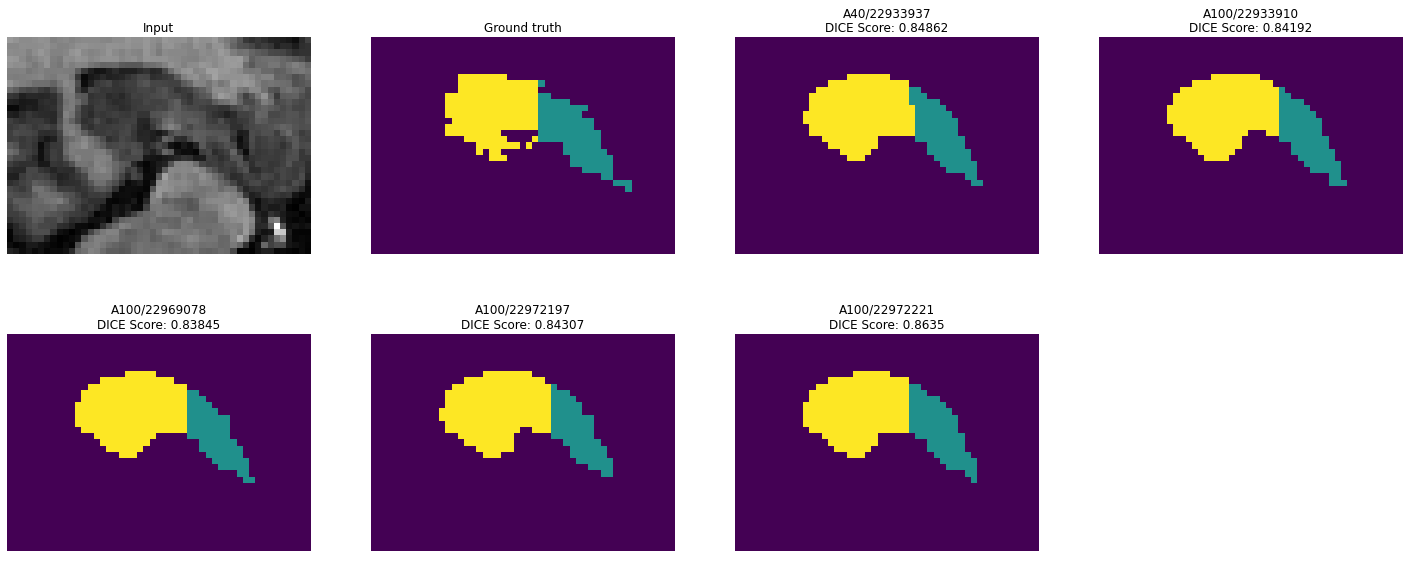

In [6]:
validation_raw_number = "350"
display_layer = 15

# Calculate the number of rows based on the size of results + 2 (input & ground truth)
# and the value of n_cols
n_cols = 4
n_rows = int(np.ceil((len(results) + 2) / n_cols))

# Define the number of rows and columns and set the graph size
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, n_rows * 5))

# Hide the graph axes
for ax in axes.flatten():
    ax.axis("off")

# Display the input image as the first image
axes[0, 0].imshow(
    nib.load(
        "./Task04_Hippocampus/ground_truth/imagesTr/hippocampus_%s.nii.gz"
        % (validation_raw_number)
    ).get_fdata()[:, :, display_layer],
    cmap="gray",
)
axes[0, 0].set_title("Input")

# Display the ground truth as the second image
axes[0, 1].imshow(
    nib.load(
        "./Task04_Hippocampus/ground_truth/labelsTr/hippocampus_%s.nii.gz"
        % (validation_raw_number)
    ).get_fdata()[:, :, display_layer]
)
axes[0, 1].set_title("Ground truth")


for i, result in enumerate(results):

    # The first key should the run name (ie A100/12345678)
    run = list(result.keys())[0]

    image_path = (
        "%s/%s/results/fold_0/validation_raw_postprocessed/hippocampus_%s.nii.gz"
        % (path, run, validation_raw_number)
    )

    # Use i + 2 instead of i because of the input image and the ground truth always being the first 2 images

    # Calculate the row number by dividing the list item number by the number of columns and rounding down
    row = int(np.floor((i + 2) / n_cols))
    # Calculate the column number by finding the remainder of the list item number divided by the number of columns
    column = int(np.remainder((i + 2), n_cols))

    # Display the display_layer layer of the image
    axes[row, column].imshow(nib.load(image_path).get_fdata()[:, :, display_layer])
    axes[row, column].set_title(
        "%s\nDICE Score: %s" % (run, result[run][validation_raw_number]["dice_score"])
    )

### Create a dataframe with just the dice scores

In [7]:
dice_scores = pd.DataFrame(index=validation_raw_numbers, columns=run_data)

for result in results:

    run = list(result.keys())[0]

    for validation_raw_number in list(result[run].keys()):
        dice_scores[run][validation_raw_number] = result[run][validation_raw_number][
            "dice_score"
        ]

dice_scores.head()

,A40/22933937,A100/22933910,A100/22969078,A100/22972197,A100/22972221
017,0.92111,0.91897,0.92166,0.92671,0.9224
019,0.8716,0.86517,0.86989,0.87025,0.86682
033,0.88198,0.8814,0.8839,0.88494,0.8826
035,0.89384,0.89476,0.90189,0.89444,0.90059
037,0.83965,0.83612,0.83784,0.84064,0.83693


### Create a new column with the dice score range

In [8]:
dice_scores["range"] = dice_scores.max(axis=1) - dice_scores.min(axis=1)

### Sort the dataframe by the dice score "range" column

In [10]:
dice_scores.sort_values(by=["range"], ascending=False).head()

,A40/22933937,A100/22933910,A100/22969078,A100/22972197,A100/22972221,range
350,0.84862,0.84192,0.83845,0.84307,0.8635,0.02505
049,0.91089,0.90729,0.92999,0.91869,0.9217,0.02270
217,0.85667,0.86264,0.86498,0.87501,0.86899,0.01834
107,0.90698,0.90473,0.90735,0.89136,0.90813,0.01677
280,0.83062,0.81762,0.83147,0.82712,0.81553,0.01594
